In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
#import pyDOE
from GenDataBallDrop1 import *
from invertH import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction
from sepia.SepiaPredict import SepiaFullPrediction

## Ball Drop with Varying Radii
Consider dropping balls of various radii $R$ from a tower at heights 5, 10, 15, and 20 meters. Each dropped ball experiment produces vector output in the form of a height-time curve, i.e., a curve showing the time as a function of the current height $t=t(h)$ of the ball at a set of defined heights $h$.

We will generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $g$ is the acceleration due to gravity, $C$ is the coefficient of drag, and R is the radius of the ball. We will refer to data generated from equation (1) as system observations. To illustrate the modeling of discrepency between simulator and reality, we will generate simulated data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\frac{dh}{dt}
\end{equation}
Note the simulated data will be systematically biased from the experimental data as it is generated with a linear velocity term $(dh/dt)$ rather than a squared velocity term. We will explicitly model this discrepecy.

These differential equations can be solved for height $h$ as a function of time $t$, ball radius $R$, and drag $C$. Observations will be the inverse: time recorded as a function of height, radius, and drag calculated by an optimizer from the scipy library in Python.

Acceleration due to gravity $g$ is assumed to be known, but the coefficient of drag $C$ is not, and is the target of inference. That is, the goal is to find the posterior distribution of $C$ that corresponds to the Sepia statistical model fit to all available data.

The first step is to compute system observations from (1) and simulated data from (2). As is standard practice in the study of computer codes a (space-filling) Latin hypercube (LH) design is used to effieintly collect simulator data over the domain of model parameters, in this case $(R,C)$.

Suppose we have data from $n=3$ experiments, one each for balls of radius $R={0.1,0.2,0.4}$ meters. Each experiment produces a curve of drop times made of three or four height-time pairs. The experimental heights are $h_e={5,10,15,20}$ meters. We assume a zero mean, normally distributed observation error $\epsilon \sim N(0,et)$ and fix $C=0.1*4\pi/3$, the coefficient of drag for a sphere.

In [4]:
n = 3                          # numer of experiements
g = 9.8                        # gravity
et = 0.01                      # observation error
C_true = 0.1 / (4 * np.pi / 3) # coefficient of drag
R = np.array([0.1,0.2,0.4])    # radii of balls

h_field = np.linspace(5,20,4)  # observed heights
y_field = invertHtrue(h_field, g, C_true, R, et) # observed times

We compute experimental data on a dense grid and plot the noisy data below.

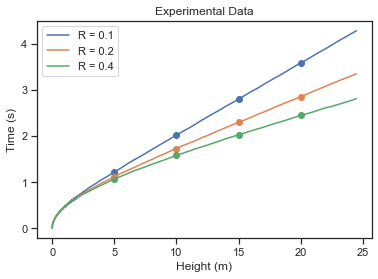

In [5]:
h_dense = np.concatenate((np.arange(0,2,.01),np.arange(2,25,.5)))
y_field_dense = invertHtrue(h_dense, g, C_true, R, et)
for i in range(n):
    plt.plot(h_dense,y_field_dense[i,:],label="R = {}".format(R[i]))
    plt.scatter(h_field,y_field[i,:])
plt.xlabel('Height (m)');plt.ylabel("Time (s)");plt.title("Experimental Data")
plt.legend()

For simulation design points, we use a scaled latin hypercube to select $m=25\;(R,C)$ pairs. We then scale the design so $R\in[0.05,0.45]$ to better match experimental data and $C\in[0.05,0.25]$ is chosen with some hindsight. The simulator will be run at these 25 design points and will return a time curve at 16 evenly spaced heights between 1.5 and 25 meters.

Text(0.5, 1.0, 'Simulator Design')

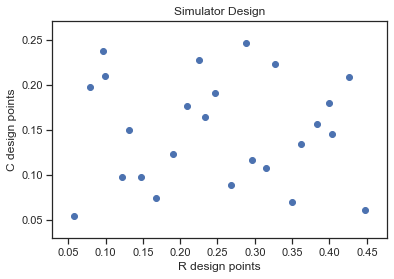

In [6]:
m=25
#sim_design = pyDOE.lhs(2,m) # to generate another design
design_names = ("R","C")
sim_design = np.array([
    [0.1239,    0.8024],
    [0.8738,    0.6473],
    [0.6140,    0.3337],
    [0.8833,    0.4783],
    [0.9946,    0.0548],
    [0.1178,    0.9382],
    [0.1805,    0.2411],
    [0.6638,    0.2861],
    [0.2939,    0.1208],
    [0.2451,    0.2397],
    [0.4577,    0.5696],
    [0.4377,    0.8874],
    [0.0737,    0.7384],
    [0.6931,    0.8683],
    [0.4901,    0.7070],
    [0.5953,    0.9828],
    [0.7506,    0.1009],
    [0.7783,    0.4225],
    [0.8333,    0.5318],
    [0.3987,    0.6312],
    [0.2021,    0.4990],
    [0.3495,    0.3680],
    [0.9411,    0.7935],
    [0.0198,    0.0218],
    [0.5440,    0.1925]])
sim_design[:,0] = sim_design[:,0] * .4 + .05
sim_design[:,1] = sim_design[:,1] * .2 + .05
R_sim = sim_design[:,0]
C_sim = sim_design[:,1]
plt.scatter(R_sim,C_sim) # consider this the "native scale for R and C"
plt.xlabel("R design points");plt.ylabel("C design points")
plt.title("Simulator Design")

Text(0.5, 1.0, 'Simulator Output for m=25 (R,C) Pairs')

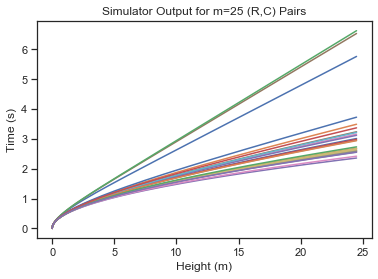

In [7]:
# Compute simulated data
h_sim = np.arange(1.5,25,1.5)
y_sim = invertHsim(h_sim, g, C_sim, R_sim)

# plot on dense grid
y_sim_dense = invertHsim(h_dense, g, C_sim, R_sim)
for i in range(m): plt.plot(h_dense,y_sim_dense[i,:])
plt.xlabel('Height (m)'); plt.ylabel("Time (s)")
plt.title("Simulator Output for m=25 (R,C) Pairs")

See invertH.py for details on solving and inverting equations (1) and (2) to obtain experimental and simulated data. Below we show, for each Radius R, the physical reality, defined by equation (1), the noisy observations, and all 25 simulation realizations. For each R, the 3 simulations with design points nearest to R are shown as red, green, and blue lines.

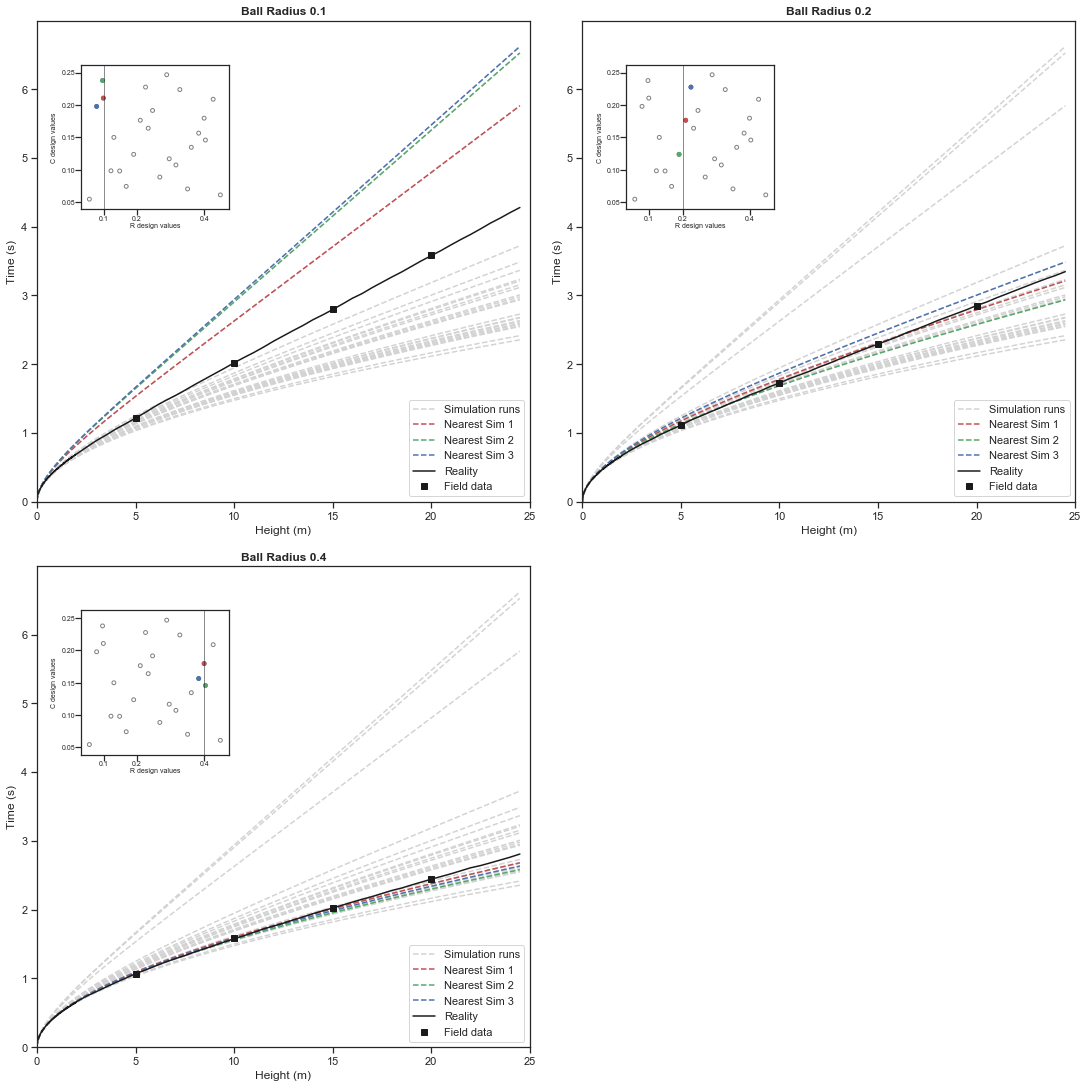

In [8]:
y_max = max(max(y_field.max(1)),max(y_sim.max(1))) # max of all row maxes for axis limit
# The ith column of R_nearest_des contains indicies of nearest n_neighbors design points
# for ith value of R.
n_neighbors = 3
R_nearest_des = np.zeros(shape=(n_neighbors,len(R)),dtype=int)
for i in range(len(R)):
    dist = np.argsort(np.abs(R_sim-R[i]))
    R_nearest_des[:,i] = dist[0:n_neighbors]
    
# Plot for each radius
colors = ('r', 'g', 'b')
fig = plt.figure(figsize=[15,15],constrained_layout=True)
gs = GridSpec(2,2,figure=fig)
axs = np.array([fig.add_subplot(gs[0,0]),\
                fig.add_subplot(gs[0,1]),\
                fig.add_subplot(gs[1,0])])
for i in range(len(R)):
    # axis limits, ticks, and labels
    axs[i].set_xlim([0, 25])
    axs[i].set_ylim([0, y_max+.5])
    axs[i].xaxis.set_ticks(np.arange(0,30,5))
    axs[i].yaxis.set_ticks(np.arange(0,y_max+.5,1))
    axs[i].set_title("Ball Radius {}".format(R[i]),fontweight="bold")
    axs[i].set_xlabel("Height (m)")
    axs[i].set_ylabel("Time (s)")
    
    # simulations - all
    for j in range(m):
        axs[i].plot(h_dense, np.transpose(y_sim_dense)[:,j],color='lightgrey',\
                linestyle="--",label="Simulation runs" if j==0 else "")
    
    # simulations - nearest neighbors
    for j in range(n_neighbors):
        axs[i].plot(h_dense,np.transpose(y_sim_dense)[:,R_nearest_des[j,i]],\
                    linestyle="--",\
                    color=colors[j],label="Nearest Sim {}".format(j+1))
    
    # Reality curve and observed data points
    axs[i].plot(h_dense, y_field_dense[i,:],'k',label="Reality")
    axs[i].plot(h_field, y_field[i,],'ks',label="Field data")
    
    axs[i].legend(loc="lower right")
    
    # imbed design point subplot
    inset_ax = inset_axes(axs[i],width="30%",height="30%",loc="upper left",\
                          borderpad=4)
    inset_ax.set_xlabel("R design values",fontsize=7,labelpad=1)
    inset_ax.set_ylabel("C design values",fontsize=7)
    inset_ax.xaxis.set_ticks(R)
    inset_ax.yaxis.set_ticks(np.arange(0,.251,.05))
    inset_ax.tick_params(axis='both', which='major', labelsize=7, pad = 0)
    inset_ax.scatter(R_sim,C_sim,s=15, facecolors='none', edgecolors='grey')
    inset_ax.scatter(R_sim[R_nearest_des[:,i]],C_sim[R_nearest_des[:,i]],s=15,\
                     color=colors)
    inset_ax.axvline(x=R[i], ymin=0, ymax=1,color='k',linewidth=.5)

# Preparing the data for Sepia
To use Sepia, we must package our data into a SepiaData object. In this example, the known inputs to the simulator are simply the vector of radii R_sim. We pass this into x_sim as a column vector. Similarly, C_sim is passed into t_sim as a column vector and is the parameter to be calibrated. We also pass in y_sim, the simulated time-height curves, and h_sim the heights associated with those times in y_sim. For the observed data, x_obs get the experimental radii R, and y_obs gets the experimental time-height curves generated from (1). Finally we pass in the heights at which the experimental time observations were taken, y_ind_obs = h_field.

In [9]:
data = SepiaData(x_sim = np.reshape(R_sim,(len(R_sim),1)),
                 t_sim = np.reshape(C_sim,(len(C_sim),1)), 
                 y_sim = y_sim, y_ind_sim = h_sim,
                 x_obs = np.reshape(R,(len(R),1)), y_obs = y_field, y_ind_obs=h_field)

### Transforming x, t, and y
Sepia required that the inputs $x,t$ lie in the interval $[0,1]^{p+q}$, and the responses $y_{sim},y_{obs}$ be $N(0,1)$.

In [10]:
data.transform_xt()
data.standardize_y()

### Generate K and D bases
Sepia models multivariate observations and responses using a linear basis. These *principal components*, or scaled eigenvectors, are computed by the singular value decomposition.

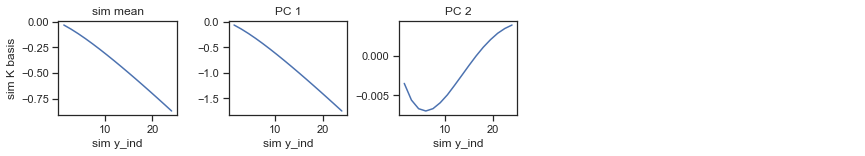

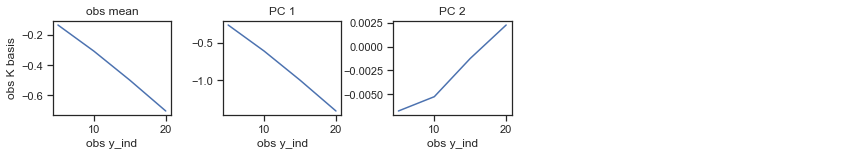

In [11]:
data.create_K_basis(2)
data.plot_K_basis()

The discrepency basis matrices D_sim and D_obs will be computed by centering normal kernels at heights h_sim and h_obs. We place normal basis kernels one standard deviation appart to ensure that no sparsity effects appear.

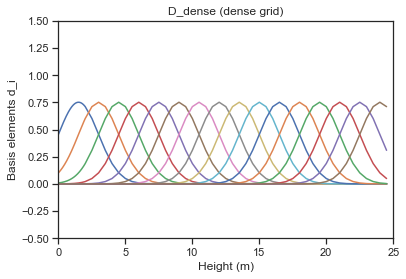

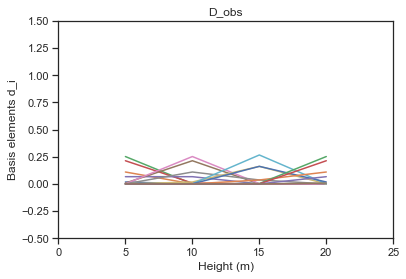

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 16, obs y dimension 4
n  =     3 (number of observed data)
m  =    25 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     2 (transformed response dimension)
pv =    16 (transformed discrepancy dimension)



In [12]:
# Generate D matrix with normal kernels
D_grid = h_sim # locations on which the kernels are centered
D_width = 1.5  # width of each kernel
pv = len(D_grid)
D_obs = np.zeros(shape=(len(h_field),pv))
D_sim = np.zeros(shape=(len(h_sim),pv))
D_dense = np.zeros(shape=(len(h_dense),pv))
# create each kernel
for j in range(pv):
    # create kernel j for each experiment
    D_obs[:,j] = norm.pdf(h_field, D_grid[j], D_width)
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)

# normalize D to match priors (should be able to remove this code now)
D_max = np.max(np.matmul(D_sim,D_sim.T))
D_sim = D_sim / np.sqrt(D_max)
D_dense = D_dense / np.sqrt(D_max)

data.create_D_basis(D_obs=D_obs.T,D_sim=D_sim)

plt.ylim(-.5,1.5)
plt.xlim(0,25)
plt.plot(h_dense,D_dense)
plt.xlabel("Height (m)");plt.ylabel("Basis elements d_i");plt.title("D_dense (dense grid)")
plt.show()
plt.ylim(-.5,1.5)
plt.xlim(0,25)
plt.plot(h_field,D_obs)
plt.xlabel("Height (m)");plt.ylabel("Basis elements d_i");plt.title("D_obs")
plt.show()

print(data)

We can visually check that our principal component weights are reasonable. In an ideal setting, weights would follow a standard normal distribution.

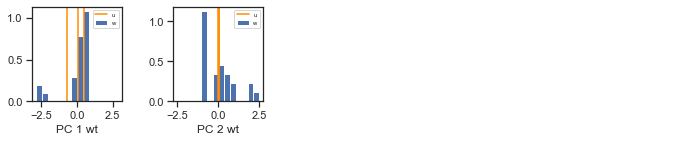

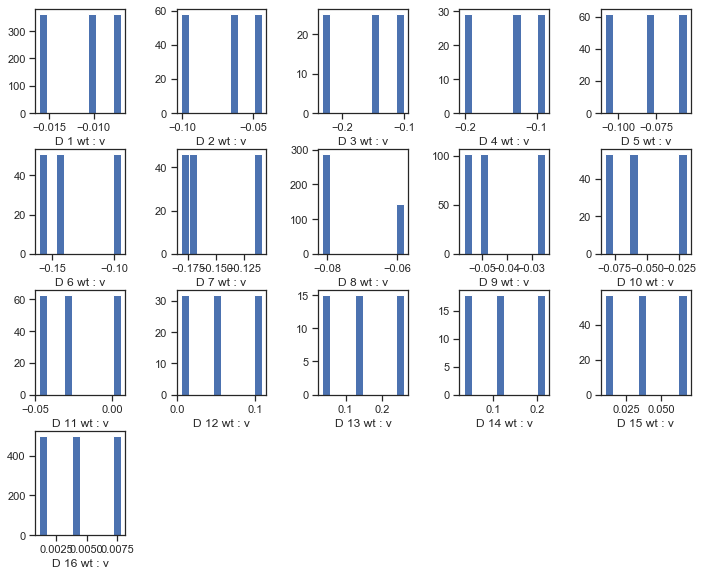

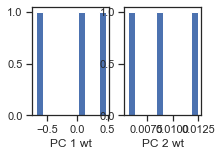

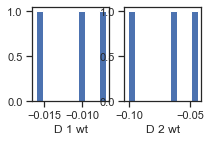

Plotting up to 5 pairs. Change with parameter 'max_plots'


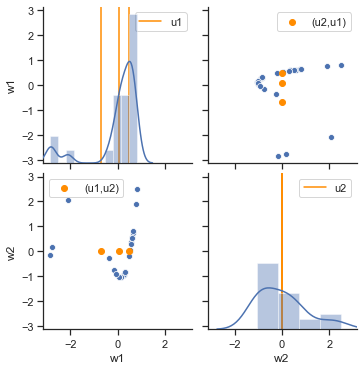

In [13]:
data.plot_K_weights()
data.plot_K_residuals()
data.plot_u_w_pairs()

# Model initialization and MCMC
Now that our data is appropiately transformed, and out bases set, the model can be initialized and the posterior distributions of parameters sampled via Markov chain Monte Carlo (MCMC). Before performing MCMC, we call tune_step_sizes() to optimize proposal widths for each parameter.

In [14]:
model = setup_model(data)
cachefile_name='ball_drop_1.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

theta 0.12061656204575083 0.007557587640838448
betaV 0.252300532901027 0.29595819583460864
betaU 8.613255064768682 2.1839542793624953
betaU 0.6242587379465268 0.27524617113198446
betaU 4.401500237701789 2.5328220998814133
betaU 3.454263532848236 2.3998083663105354
lamVz 95.36864651805105 83.4942478343251
lamUz 0.4499266121269004 0.1291106536813584
lamUz 0.8497843165172791 0.30731480433853076
lamWs 578.2908160374643 337.5376130941542
lamWs 965.694909861826 572.2169079511833
lamWOs 28562.990321629044 2184.079463948316
lamOs 21661.27893578391 4623.777573317285


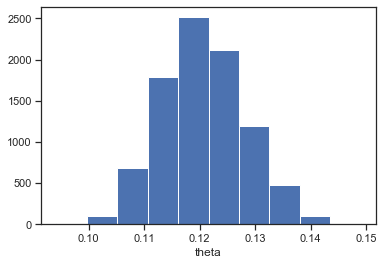

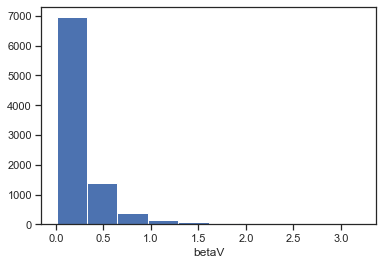

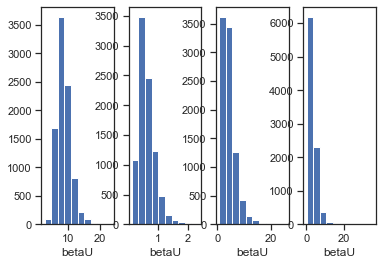

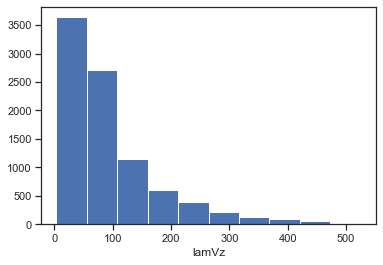

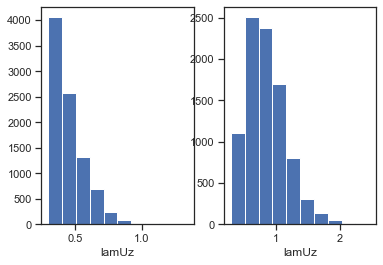

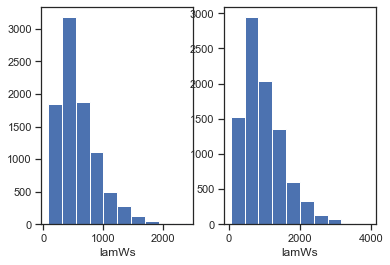

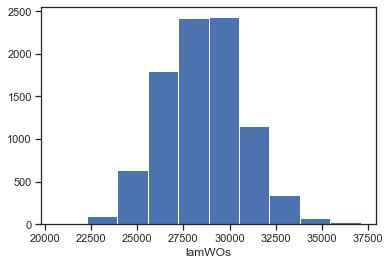

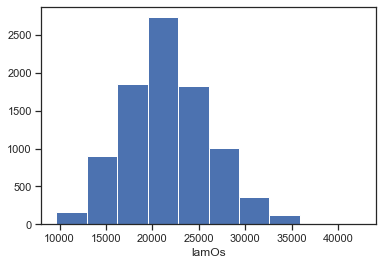

In [15]:
# Extract MCMC samples into dictionary with parameter names
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}

for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
        print(k,np.mean(samples_dict[k][:, j]),np.std(samples_dict[k][:, j]))

# Assessing emulator adequacy
It is important to examine diagnostics to understand the quality of the emulator in reproducing the simulator output at new, untried settings. The following are usful ways to asses the quality of the emulator fit.

### Principal components

### Parameters in the Gaussian Process Fit
Using the MCMC draws of the spacial dependence parameters $\beta$, $\rho=exp\{-\beta/4\}$ can be calculated to show the values on the more interpretable $[0,1]$ scale. The values of $\rho$ give us information about the dependence of the simulation output on each input parameter $x$ and $\theta$. We show boxplots of the posterior draws for $\rho$ for each $x$ and $\theta$. and for each principal component.  
When $\rho$ is near 1, it suggests that particular component of the simulator output in linear in that dimention. As $\rho$ goes smaller, nonlinear activity is associated with that input. In other words larger values of $\rho$ indicate more smoothness. Additionally, smaller values of $\rho$ indicate increasing flexibility in the model response. Very small values could indicate overfitting. Thus, if any of the boxplots show values very near to zero, the model is suspect. The boxplots below are for correlation parameters associated with the K-basis. Discrepency basis correlation parameters could be similarly assesed.

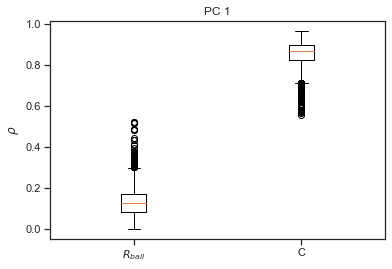

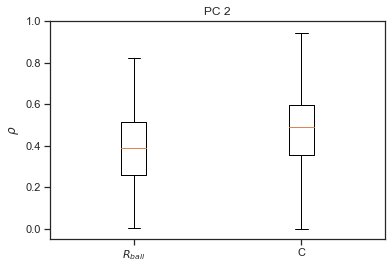

In [16]:
p = 1
q = 1
pu = 2
# rho box plots
bu = samples_dict['betaU']
ru = np.exp(-bu / 4)
for i in range(pu):
    r = ru[:, ((p+q)*i):((p+q)*i)+(p+q)]
    plt.boxplot(r)
    plt.xticks([1,2],[r'$R_{ball}$','C'])
    plt.yticks(np.arange(0,1.2,.2))
    plt.ylabel(r'$\rho$')
    plt.title('PC {}'.format(i+1))
    plt.show()

----
## Predictions of model output from the full model

First, predictions showing just the emulator response, using
SepiaEmulatorPredict

In [17]:
model.verbose=True
x_pred=data.obs_data.x
n_pred=x_pred.shape[0]
#post_mean_t=p_stats['mean'][0]
#t_pred=np.reshape(np.repeat(post_mean_t,x_pred.shape[0]),(n_pred,model.num.q))
pred_samples=model.get_samples(numsamples=25)
pred=SepiaEmulatorPrediction(x_pred=x_pred, samples=pred_samples, model=model)#, t_pred=t_pred)

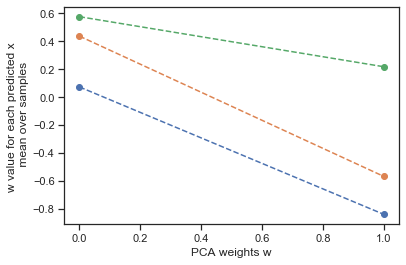

In [18]:
predw=pred.get_w()
plt.figure()
plt.plot(np.mean(predw,0).T,'--o')
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

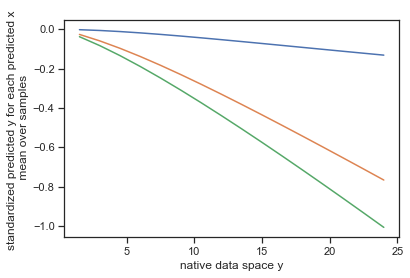

In [19]:
predystd=pred.get_y_standardized()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted y for each predicted x \n mean over samples')
plt.show()

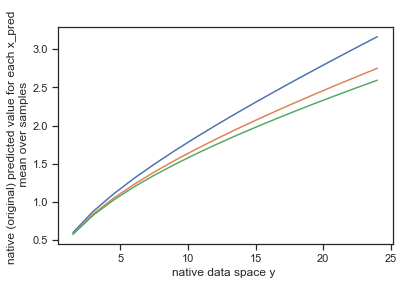

In [20]:
predy=pred.get_y_native()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy,0).T)
plt.xlabel('native data space y ')
plt.ylabel('native (original) predicted value for each x_pred \n mean over samples')
plt.show()

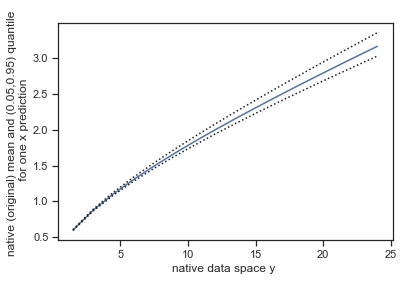

In [21]:
predy=pred.get_y_native()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predy[:,0,:],0).T)
plt.plot(model.data.sim_data.y_ind,np.quantile(predy[:,0,:],[0.05, 0.95],axis=0).T,'k:')
plt.xlabel('native data space y ')
plt.ylabel('native (original) mean and (0.05,0.95) quantile \n for one x prediction')
plt.show()

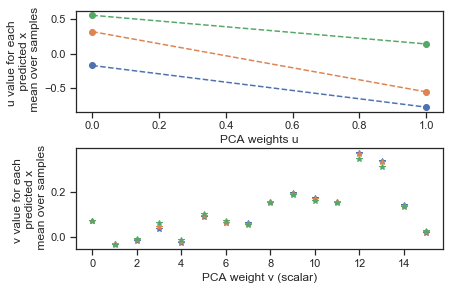

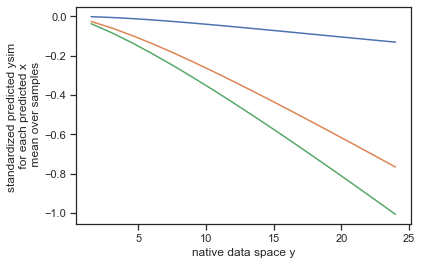

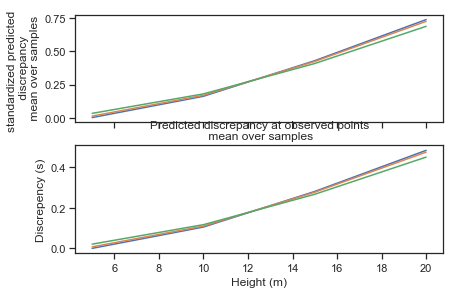

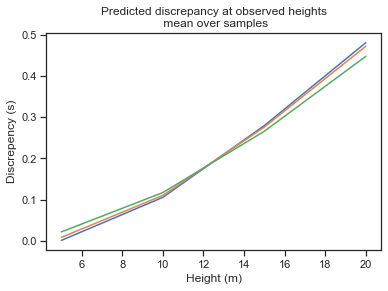

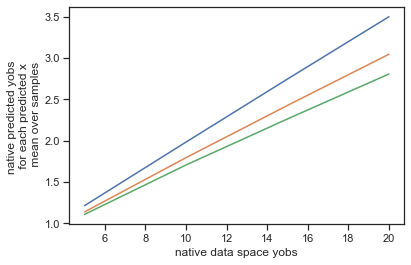

In [22]:
from sepia.SepiaPredict import SepiaFullPrediction
x_pred=data.obs_data.x
pred_samples=model.get_samples(numsamples=25)
pred=SepiaFullPrediction(x_pred, pred_samples, model)

predu, predv = pred.get_u_v()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()
ax1.plot(np.mean(predu,0).T,'--o')
ax1.set_xlabel('PCA weights u')
ax1.set_ylabel('u value for each \n predicted x \n mean over samples')
ax2.plot(np.mean(predv,0).T,'*')
ax2.set_xlabel('PCA weight v (scalar)')
ax2.set_ylabel('v value for each \n predicted x \n mean over samples')
plt.show()

predysimstd=pred.get_ysim_standardized()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predystd,0).T)
plt.xlabel('native data space y')
plt.ylabel('standardized predicted ysim \n for each predicted x \n mean over samples')
plt.show()

preddstd=pred.get_discrepancy_standardized()
predd=pred.get_discrepancy_native()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.tight_layout()
ax1.plot(model.data.obs_data.y_ind,np.mean(preddstd,0).T)
#ax1.set_xlabel('native data space y \n ($\delta$ is constant in this example)')
ax1.set_ylabel('standardized predicted \n discrepancy\n mean over samples')
ax2.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
ax2.set_xlabel('Height (m)')
ax2.set_ylabel('Discrepency (s)')
ax2.set_title('Predicted discrepancy at observed points\n mean over samples')
plt.show()

fit, ax = plt.subplots()
ax.plot(model.data.obs_data.y_ind,np.mean(predd,0).T)
ax.set_xlabel('Height (m)')
ax.set_ylabel('Discrepency (s)')
ax.set_title('Predicted discrepancy at observed heights\n mean over samples')
plt.show()


predyobs=pred.get_yobs_native()
plt.figure()
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs,0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs \n for each predicted x \n mean over samples')
plt.show()

### Summary plot of predicted uncertainty for an observation.
The 5th prediction done corresponds to the observation in the model, with xpred=0.5.

/Users/granthutchings/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a26733890> has a label of '_' which cannot be automatically added to the legend.
  app.launch_new_instance()


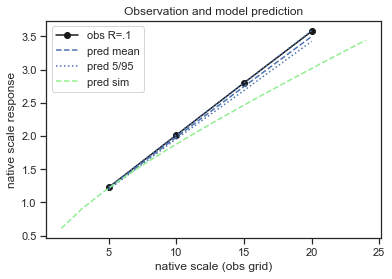

In [23]:
predyobs=pred.get_yobs_native()
predysim=pred.get_ysim_native()
plt.figure()
colors = ('r','g','b')
R_idx = 0
#for i in range(model.data.obs_data.y.shape[0]):
#    plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y[i,:],color=colors[i],marker='o')
plt.plot(model.data.obs_data.y_ind,model.data.obs_data.y[R_idx,:],c='k',marker='o')
plt.plot(model.data.obs_data.y_ind,np.mean(predyobs[:,R_idx,:],0).T,'b--')
plt.plot(model.data.obs_data.y_ind,np.quantile(predyobs[:,R_idx,:],[0.05, 0.95],axis=0).T,'b:')
plt.plot(model.data.sim_data.y_ind,np.mean(predysim[:,R_idx,:],0).T,'--',c='lightgreen')
plt.xlabel('native scale (obs grid)')
plt.ylabel('native scale response')
plt.title('Observation and model prediction')
#plt.legend(['obs R=.1','obs R=.2','obs R=.4','pred mean','_','pred 5/95','pred sim'])
plt.legend(['obs R=.1','pred mean','_','pred 5/95','pred sim'])
plt.show()